In [ ]:
!nvidia-smi

In [ ]:
!pip install timm~=0.4.12
!pip install scikit-learn~=1.0.2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
%cd /content/drive/MyDrive/MonkeyPox

/content/drive/MyDrive/MonkeyPox


In [2]:
!ls

 cnn+lstm.ipynb   ens_csp.json	 main.ipynb	        result_analysis.ipynb
 CNNs		  ens_csp.pth	'Model Evals.ipynb'     train.py
 dataset	  ens_nas.json	'Mssodel Evals.ipynb'
 dataset.zip	  ens_nas.pth	 __pycache__


In [3]:
import torch
import timm
import torch.nn as nn
import os
from torchvision import datasets,transforms
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


import torch
import matplotlib
import numpy as np
import seaborn as sns
from itertools import cycle
import matplotlib.pyplot as plt

In [4]:
from sklearn.metrics import cohen_kappa_score,classification_report,confusion_matrix,roc_curve,roc_auc_score,matthews_corrcoef

In [5]:
data_dir = './dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
pretrained_size = 224

pretrained_means = [0.485,0.456,0.406]

pretrained_stds= [0.229,0.224,0.225]

batch_size=8

In [8]:
classes=["Chickenpox","Measles","Monkeypox","Normal"]

In [9]:
data_transforms = {
    
    'train': transforms.Compose([
        transforms.Resize((pretrained_size,pretrained_size)),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomRotation(15),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize((pretrained_size,pretrained_size)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
        
    ])
,
    'val': transforms.Compose([
        transforms.Resize((pretrained_size,pretrained_size)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
        
    ])}

In [10]:
def valid_epoch(model,dataloader):
    model.eval()
    _labels=torch.tensor([0]).to(device)
    _predictions=torch.tensor([0]).to(device)
    for images, labels in dataloader:
        images,labels = images.to(device),labels.to(device)
        output = model(images)
        scores, predictions = torch.max(output.data,1)
        _labels = torch.cat((_labels, labels), 0)
        _predictions = torch.cat((_predictions, predictions), 0)
    get_roc_curves(model,dataloader)
    print("Report /n",classification_report(_labels[1::].cpu(), _predictions[1::].cpu()))

    print("----Report for cohen_kappa_score /n",cohen_kappa_score(_labels[1::].cpu(), _predictions[1::].cpu()))
    print("----Report for matthews_corrcoef /n",matthews_corrcoef(_labels[1::].cpu(), _predictions[1::].cpu()))

    cf=confusion_matrix(_labels[1::].cpu(), _predictions[1::].cpu())
    #df_cm = pd.DataFrame(cf / np.sum(cf, axis=1), index = [i for i in classes],
    df_cm = pd.DataFrame(cf, index = [i for i in classes],columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True,fmt='.3g')
    plt.show()
    plt.clf()

In [11]:
print("Initializing Datasets and Dataloaders...\n")
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test','val']}
# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4,pin_memory=True) for x in ['train', 'test','val']}
# Dataset size calculations
dataset_sizes ={x:len(image_datasets[x]) for x in ['train','test','val']}

Initializing Datasets and Dataloaders...



In [12]:
def test_class_probabilities(model, test_loader, which_class):
        
        truths = []
        probabilities = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data).cuda().cpu()
                prediction = output.argmax(dim=1, keepdim=True)
                truths.extend(target.view_as(prediction) == which_class)
                probabilities.extend(np.exp(output[:, which_class]))
        return [i.item() for i in truths], [i.item() for i in probabilities]

In [13]:
def get_roc_curves(model, data):  # draw Roc curves and calculate auc score for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        actuals, class_probabilities = test_class_probabilities(model, data, 0)
        fpr[0], tpr[0], _ = roc_curve(actuals, class_probabilities)
        roc_auc[0] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = test_class_probabilities(model, data, 1)
        fpr[1], tpr[1], _ = roc_curve(actuals, class_probabilities)
        roc_auc[1] = roc_auc_score(actuals, class_probabilities)
        
        
        actuals, class_probabilities = test_class_probabilities(model, data, 2)
        fpr[2], tpr[2], _ = roc_curve(actuals, class_probabilities)
        roc_auc[2] = roc_auc_score(actuals, class_probabilities)
        
        actuals, class_probabilities = test_class_probabilities(model, data, 3)
        fpr[3], tpr[3], _ = roc_curve(actuals, class_probabilities)
        roc_auc[3] = roc_auc_score(actuals, class_probabilities)
        


        print("Auc Score For Each Class: ", roc_auc)

        matplotlib.rcdefaults()
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue',"black","red"])
        for i, color in zip(range(4), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
                     label='ROC curve for {0} (area = {1:0.3f})'
                           ''.format(classes[i], roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()

In [14]:
__models={"inception_v4":"--",
"seresnet50":"--",
"cspdarknet53":"--",
"mnasnet_100":"--",
"xception71":"--",
"repvgg_b0":"--",
"tf_mobilenetv3_large_100":"--"}

In [19]:
__models={"repvgg_b0":"--",
"tf_mobilenetv3_large_100":"--"}

repvgg_b0 /n
Auc Score For Each Class:  {0: 0.9582581018518519, 1: 0.9900752314814815, 2: 0.9841666666666666, 3: 0.9949479166666666}


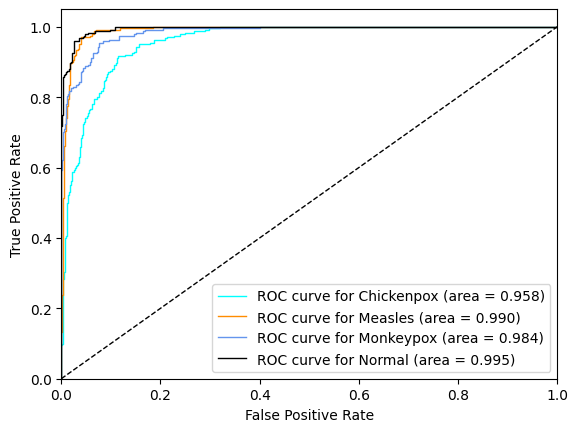

Report /n               precision    recall  f1-score   support

           0       0.86      0.98      0.92       240
           1       0.95      0.99      0.97       240
           2       0.96      0.88      0.92       240
           3       1.00      0.89      0.94       240

    accuracy                           0.94       960
   macro avg       0.94      0.94      0.94       960
weighted avg       0.94      0.94      0.94       960

----Report for cohen_kappa_score /n 0.9166666666666666
----Report for matthews_corrcoef /n 0.9181569588224147


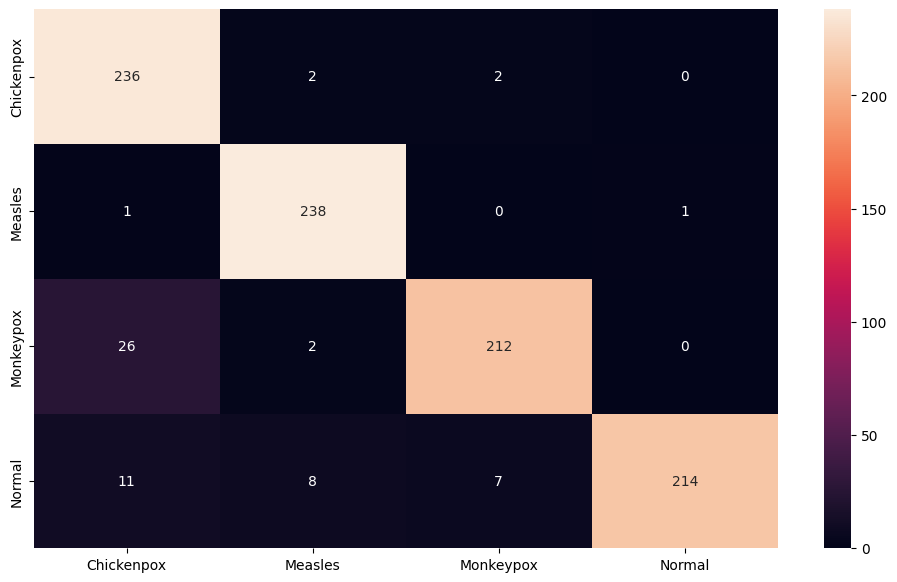

tf_mobilenetv3_large_100 /n
Auc Score For Each Class:  {0: 0.9737152777777778, 1: 0.9761342592592592, 2: 0.877019675925926, 3: 0.9808275462962963}


<Figure size 640x480 with 0 Axes>

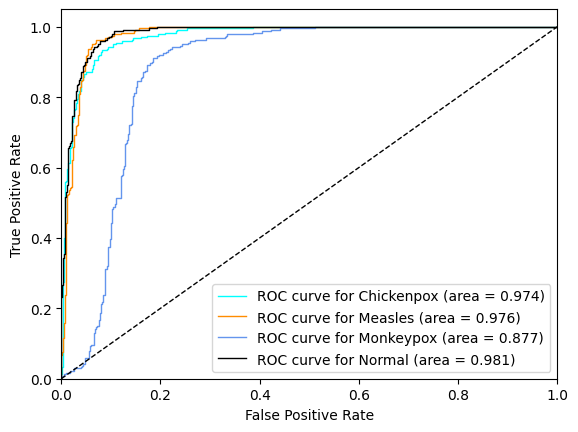

Report /n               precision    recall  f1-score   support

           0       0.97      0.98      0.98       240
           1       0.98      0.98      0.98       240
           2       0.99      0.89      0.94       240
           3       0.92      0.99      0.95       240

    accuracy                           0.96       960
   macro avg       0.96      0.96      0.96       960
weighted avg       0.96      0.96      0.96       960

----Report for cohen_kappa_score /n 0.95
----Report for matthews_corrcoef /n 0.9506535238557807


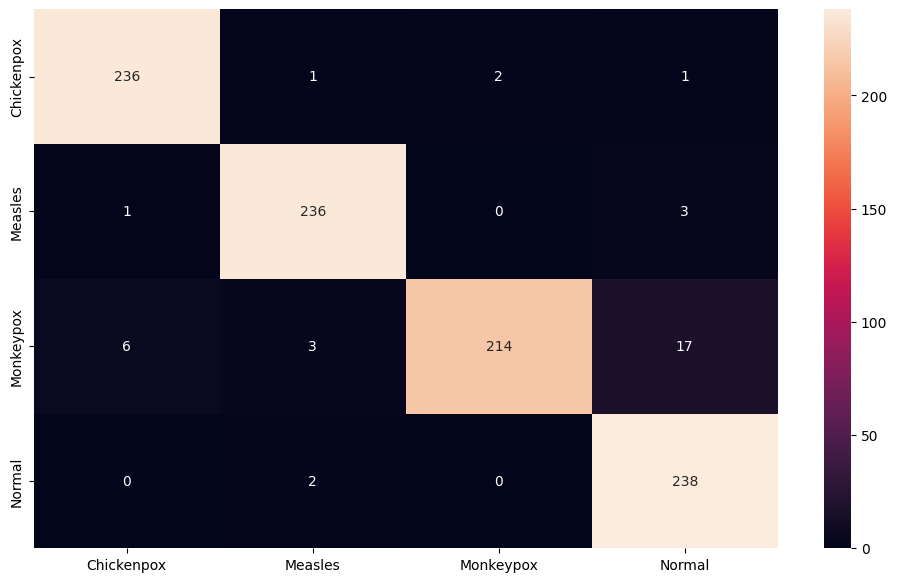

<Figure size 640x480 with 0 Axes>

In [21]:
for model_name in __models.keys():
        model = timm.create_model(model_name, pretrained=False)
        if model_name=="inception_v4":#++ 74
            model.last_linear.out_features=4
        elif model_name == "seresnet50": #++ 73
            model.fc.out_features = 4
        elif model_name == "cspdarknet53": #++ 80
            model.head.fc.out_features = 4
        elif model_name == "mnasnet_100": #++ 84
            model.classifier.out_features = 4
        elif model_name == "xception71": #++ 73
            model.head.fc.out_features = 4
        elif model_name == "repvgg_b0":
            model.head.fc.out_features = 4
        elif model_name == "tf_mobilenetv3_large_100":
            model.classifier.out_features = 4
        else:
            pass
        __model_result_path="./CNNs/"+model_name+".pth"
        model.load_state_dict(torch.load(__model_result_path))
        model.to(device)
        print(model_name,"/n")
        valid_epoch(model,dataloaders["train"])

repvgg_b0 /n
Auc Score For Each Class:  {0: 0.9174074074074073, 1: 0.9288888888888889, 2: 0.98, 3: 0.9718518518518517}


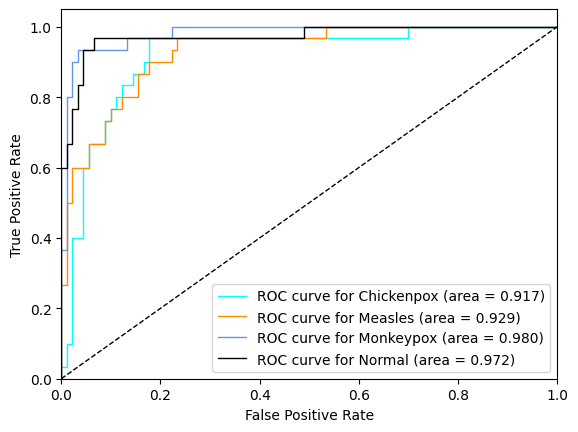

Report /n               precision    recall  f1-score   support

           0       0.84      0.90      0.87        30
           1       0.96      0.73      0.83        30
           2       0.88      0.93      0.90        30
           3       0.88      0.97      0.92        30

    accuracy                           0.88       120
   macro avg       0.89      0.88      0.88       120
weighted avg       0.89      0.88      0.88       120

----Report for cohen_kappa_score /n 0.8444444444444444
----Report for matthews_corrcoef /n 0.8470365780392037


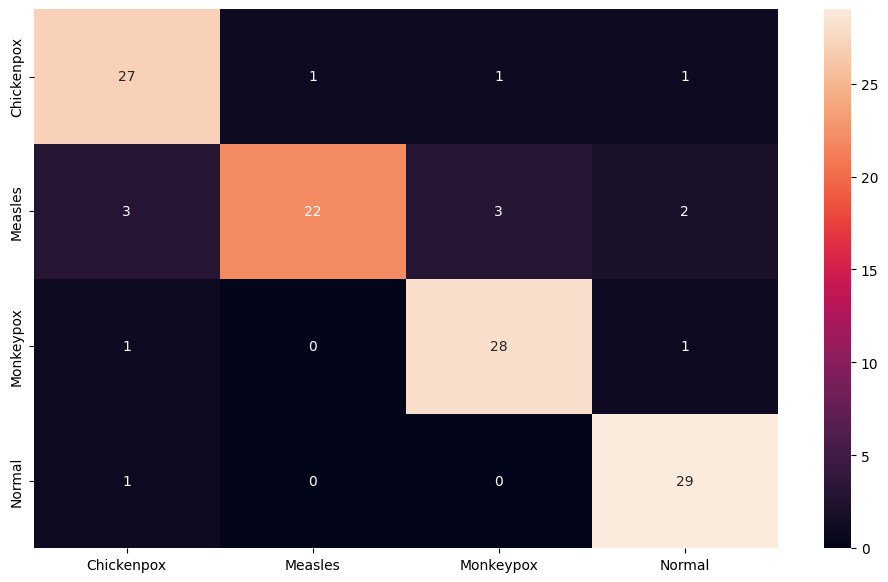

tf_mobilenetv3_large_100 /n
Auc Score For Each Class:  {0: 0.9266666666666666, 1: 0.9437037037037037, 2: 0.9303703703703704, 3: 0.9592592592592593}


<Figure size 640x480 with 0 Axes>

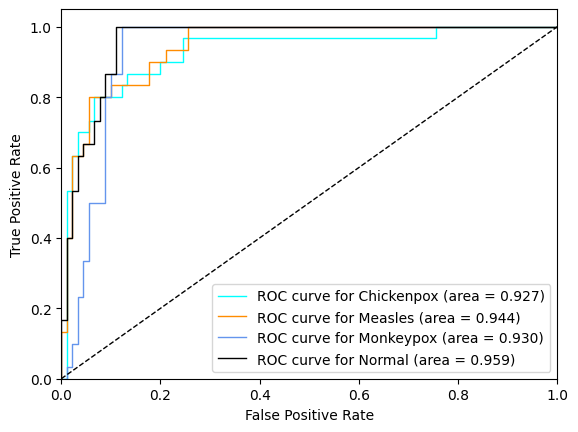

Report /n               precision    recall  f1-score   support

           0       0.96      0.80      0.87        30
           1       0.96      0.83      0.89        30
           2       0.88      0.97      0.92        30
           3       0.83      1.00      0.91        30

    accuracy                           0.90       120
   macro avg       0.91      0.90      0.90       120
weighted avg       0.91      0.90      0.90       120

----Report for cohen_kappa_score /n 0.8666666666666667
----Report for matthews_corrcoef /n 0.8701380295131786


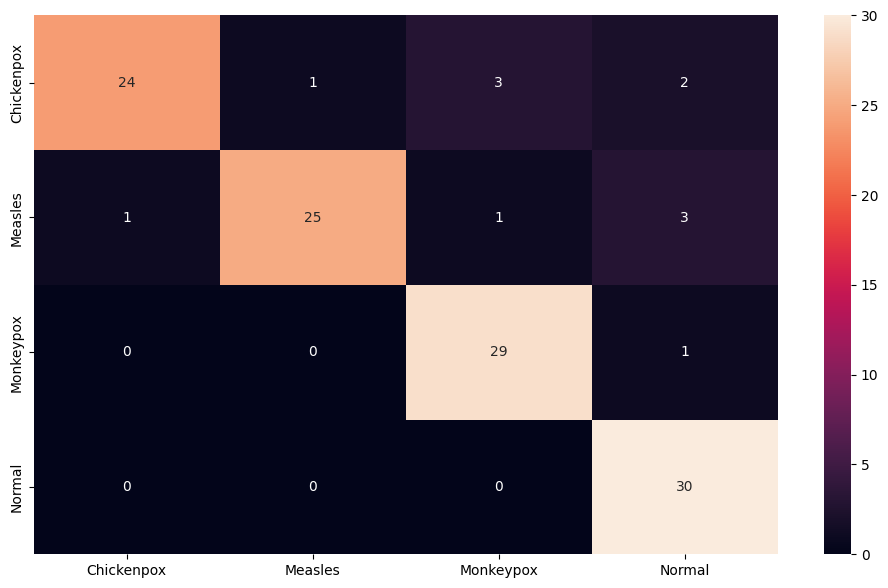

<Figure size 640x480 with 0 Axes>

In [22]:
for model_name in __models.keys():
        model = timm.create_model(model_name, pretrained=False)
        if model_name=="inception_v4":#++ 74
            model.last_linear.out_features=4
        elif model_name == "seresnet50": #++ 73
            model.fc.out_features = 4
        elif model_name == "cspdarknet53": #++ 80
            model.head.fc.out_features = 4
        elif model_name == "mnasnet_100": #++ 84
            model.classifier.out_features = 4
        elif model_name == "xception71": #++ 73
            model.head.fc.out_features = 4
        elif model_name == "repvgg_b0":
            model.head.fc.out_features = 4
        elif model_name == "tf_mobilenetv3_large_100":
            model.classifier.out_features = 4
        else:
            pass
        __model_result_path="./CNNs/"+model_name+".pth"
        model.load_state_dict(torch.load(__model_result_path))
        model.to(device)
        print(model_name,"/n")
        valid_epoch(model,dataloaders["val"])

repvgg_b0 /n
Auc Score For Each Class:  {0: 0.8455555555555555, 1: 0.9218518518518519, 2: 0.9614814814814815, 3: 0.9888888888888888}


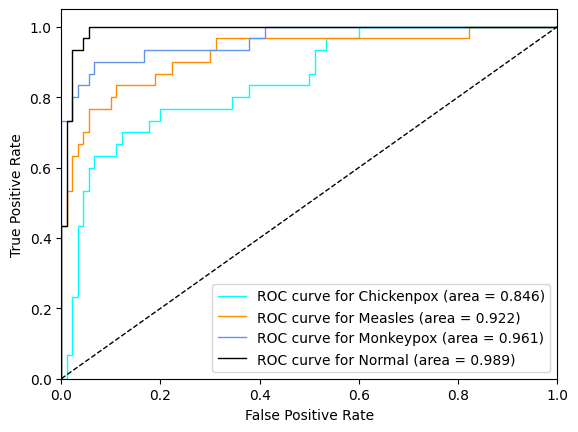

Report /n               precision    recall  f1-score   support

           0       0.73      0.80      0.76        30
           1       1.00      0.77      0.87        30
           2       0.84      0.87      0.85        30
           3       0.88      0.97      0.92        30

    accuracy                           0.85       120
   macro avg       0.86      0.85      0.85       120
weighted avg       0.86      0.85      0.85       120

----Report for cohen_kappa_score /n 0.8
----Report for matthews_corrcoef /n 0.8025304742699444


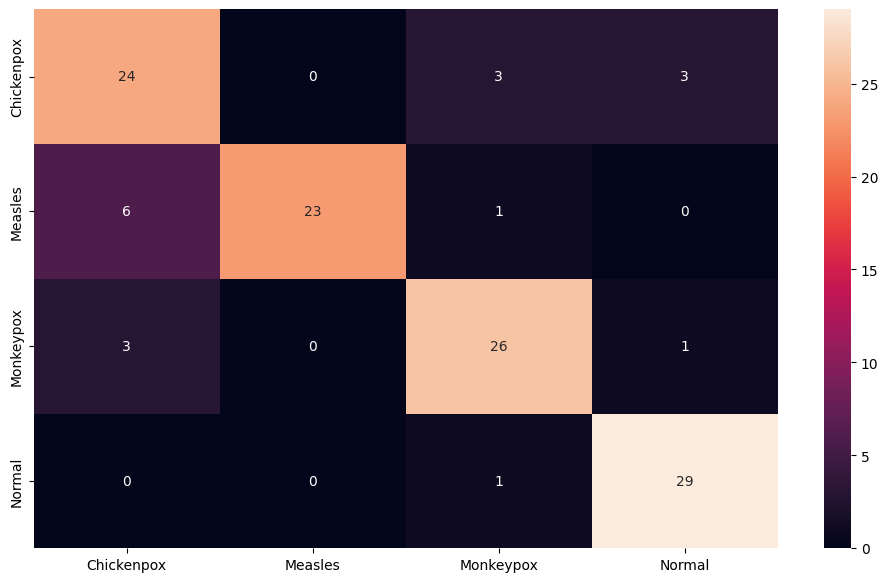

tf_mobilenetv3_large_100 /n
Auc Score For Each Class:  {0: 0.8285185185185185, 1: 0.9003703703703704, 2: 0.8725925925925926, 3: 0.9407407407407407}


<Figure size 640x480 with 0 Axes>

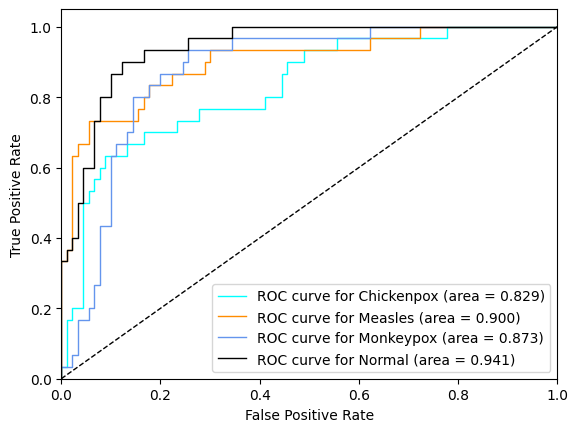

Report /n               precision    recall  f1-score   support

           0       0.76      0.63      0.69        30
           1       0.91      0.70      0.79        30
           2       0.79      0.87      0.83        30
           3       0.74      0.97      0.84        30

    accuracy                           0.79       120
   macro avg       0.80      0.79      0.79       120
weighted avg       0.80      0.79      0.79       120

----Report for cohen_kappa_score /n 0.7222222222222222
----Report for matthews_corrcoef /n 0.7277690136606382


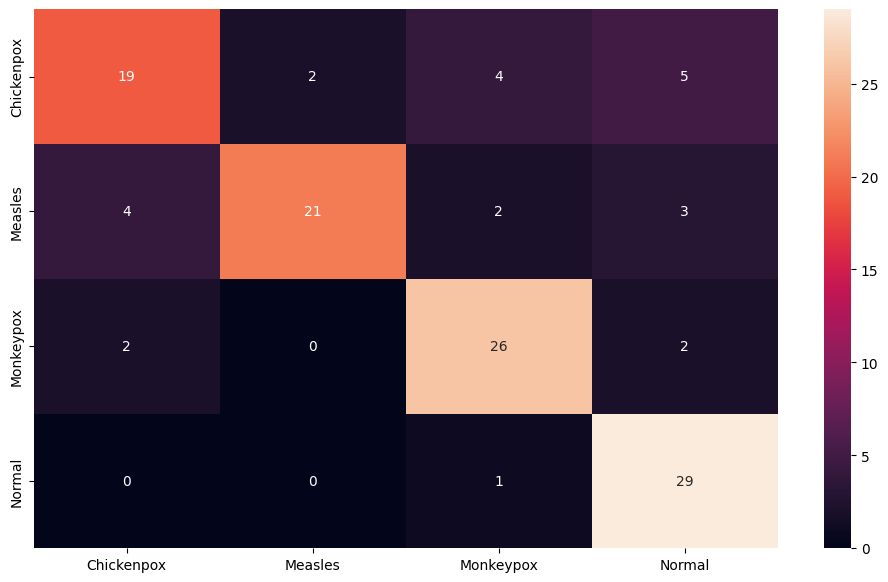

<Figure size 640x480 with 0 Axes>

In [23]:
for model_name in __models.keys():
        model = timm.create_model(model_name, pretrained=False)
        if model_name=="inception_v4":#++ 74
            model.last_linear.out_features=4
        elif model_name == "seresnet50": #++ 73
            model.fc.out_features = 4
        elif model_name == "cspdarknet53": #++ 80
            model.head.fc.out_features = 4
        elif model_name == "mnasnet_100": #++ 84
            model.classifier.out_features = 4
        elif model_name == "xception71": #++ 73
            model.head.fc.out_features = 4
        elif model_name == "repvgg_b0":
            model.head.fc.out_features = 4
        elif model_name == "tf_mobilenetv3_large_100":
            model.classifier.out_features = 4
        else:
            pass
        __model_result_path="./CNNs/"+model_name+".pth"
        model.load_state_dict(torch.load(__model_result_path))
        model.to(device)
        print(model_name,"/n")
        valid_epoch(model,dataloaders["test"])